# Importing the Libraries

In [1]:
import numpy as np # to manipulate arrays
import matplotlib.pyplot as plt # for visualization
import tensorflow as tf # for tensor operations
import tensorflow_datasets as tfds # datasets provided by tensorflow
from functools import partial # wrap the layer in a partial class
from tensorflow import keras # for deep neural network
from sklearn.datasets import load_sample_image # load image from sklearn

A couple utility functions to plot grayscale and RGB images:

In [2]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

# What is a Convolution?

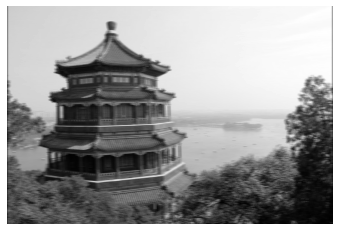

In [3]:
# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off")
plt.show()

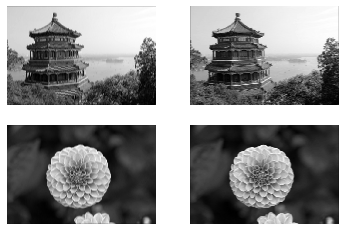

In [4]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

In [5]:
def crop(images):
    return images[150:220, 130:250]

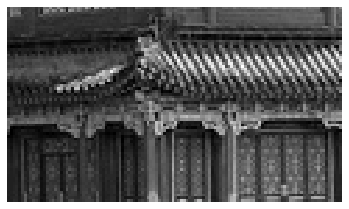

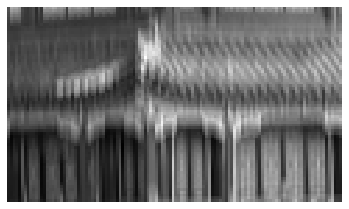

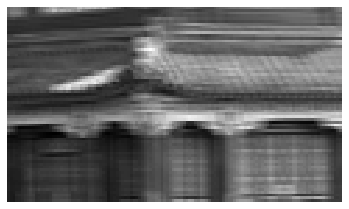

In [6]:
plot_image(crop(images[0, :, :, 0]))
plt.show()

for feature_map_index in (0, 1):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

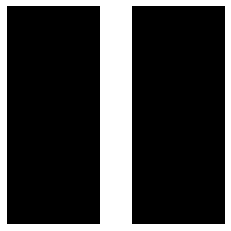

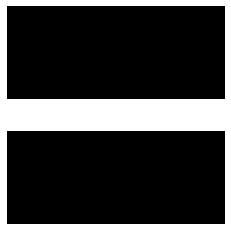

In [7]:
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()


# Convolutional Layer

Let's create a 2D convolutional layer, using `keras.layers.Conv2D()`:


In [8]:
np.random.seed(42)
tf.random.set_seed(42)

conv = keras.layers.Conv2D(filters=2, kernel_size=7, strides=1,
                           padding="SAME", activation="relu", input_shape=outputs.shape)

Let's call this layer, passing it the two test images:

In [9]:
conv_outputs = conv(images)
conv_outputs.shape

TensorShape([2, 427, 640, 2])



The output is a 4D tensor. The dimensions are: batch size, height, width, channels. The first dimension (batch size) is 2 since there are 2 input images. The next two dimensions are the height and width of the output feature maps: since `padding="SAME"` and `strides=1`, the output feature maps have the same height and width as the input images (in this case, 427×640). Lastly, this convolutional layer has 2 filters, so the last dimension is 2: there are 2 output feature maps per input image.

Since the filters are initialized randomly, they'll initially detect random patterns. Let's take a look at the 2 output features maps for each image:


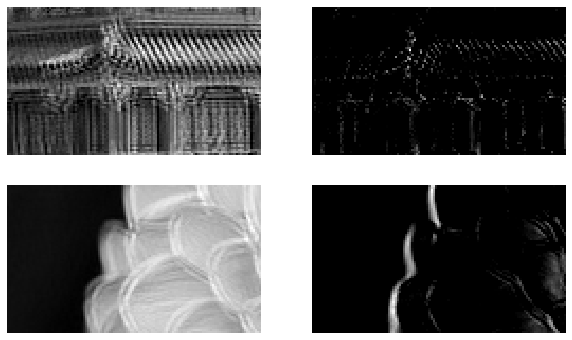

In [10]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()



Although the filters were initialized randomly, the second filter happens to act like an edge detector. Randomly initialized filters often act this way, which is quite fortunate since detecting edges is quite useful in image processing.

If we want, we can set the filters to be the ones we manually defined earlier, and set the biases to zeros (in real life we will almost never need to set filters or biases manually, as the convolutional layer will just learn the appropriate filters and biases during training):


In [11]:
conv.set_weights([filters, np.zeros(2)])

Now let's call this layer again on the same two images, and let's check that the output feature maps do highlight vertical lines and horizontal lines, respectively (as earlier):

In [12]:
conv_outputs = conv(images)
conv_outputs.shape 

TensorShape([2, 427, 640, 2])

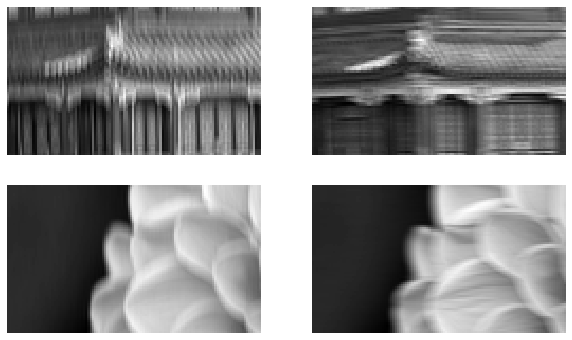

In [13]:
plt.figure(figsize=(10,6))
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(crop(conv_outputs[image_index, :, :, feature_map_index]))
plt.show()


# Pooling layer
## Max pooling

In [14]:
max_pool = keras.layers.MaxPool2D(pool_size=2)

In [15]:
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)
output = max_pool(cropped_images)

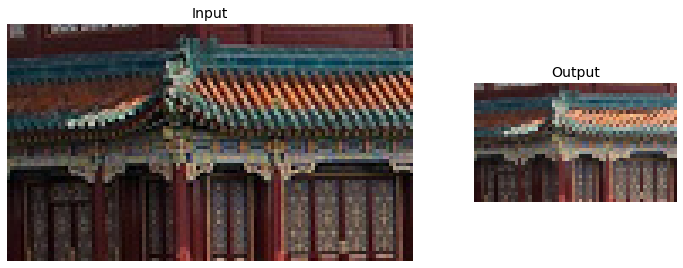

In [16]:
import matplotlib as mpl

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Depth-wise pooling

In [17]:
class DepthMaxPool(keras.layers.Layer):
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    def call(self, inputs):
        return tf.nn.max_pool(inputs,
                              ksize=(1, 1, 1, self.pool_size),
                              strides=(1, 1, 1, self.pool_size),
                              padding=self.padding)

In [18]:
depth_pool = DepthMaxPool(3)
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])



Or just use a `Lambda` layer:


In [19]:
depth_pool = keras.layers.Lambda(lambda X: tf.nn.max_pool(
    X, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3), padding="VALID"))
with tf.device("/cpu:0"): # there is no GPU-kernel yet
    depth_output = depth_pool(cropped_images)
depth_output.shape

TensorShape([2, 70, 120, 1])

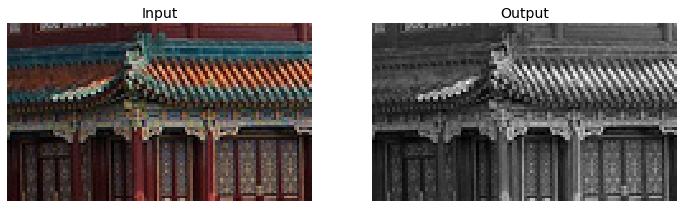

In [20]:
plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])  # plot the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])  # plot the output for the 1st image
plt.axis("off")
plt.show()

## Average pooling

In [21]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)

In [22]:
output_avg = avg_pool(cropped_images)

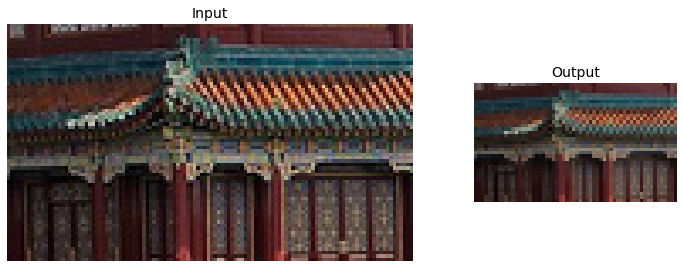

In [23]:
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

## Global Average Pooling

In [24]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

In [25]:
output_global_avg2 = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg2(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788777 , 0.22507192, 0.20967275],
       [0.51288515, 0.45951638, 0.33423486]], dtype=float32)>

# Tackling Fashion MNIST With a CNN

In [26]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [27]:
DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])

In [28]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.7105 - accuracy: 0.7539 - val_loss: 0.3790 - val_accuracy: 0.8702
Epoch 2/10
1719/1719 [==============================] - 14s 8ms/step - loss: 0.4237 - accuracy: 0.8582 - val_loss: 0.3260 - val_accuracy: 0.8814
Epoch 3/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3614 - accuracy: 0.8799 - val_loss: 0.3000 - val_accuracy: 0.8852
Epoch 4/10
1719/1719 [==============================] - 21s 12ms/step - loss: 0.3356 - accuracy: 0.8889 - val_loss: 0.2944 - val_accuracy: 0.8908
Epoch 5/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3119 - accuracy: 0.8961 - val_loss: 0.2800 - val_accuracy: 0.8938
Epoch 6/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2953 - accuracy: 0.9001 - val_loss: 0.2672 - val_accuracy: 0.9026
Epoch 7/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.2772 - accuracy: 0.9062 - val_loss: 0.2565 - val_a

In [29]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 1s 4ms/step - loss: 0.2992 - accuracy: 0.8995


[0.29921695590019226, 0.8995000123977661]

In [30]:
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)
y_pred

array([[6.8493010e-27, 2.8431937e-26, 1.6513435e-26, 3.0512678e-26,
        2.9498772e-32, 4.6414173e-10, 3.9805139e-26, 2.2639986e-05,
        3.3436424e-25, 9.9997735e-01],
       [7.2320682e-07, 1.9946942e-16, 9.9852920e-01, 6.0287799e-13,
        4.4774260e-05, 6.1392225e-22, 1.4253275e-03, 4.5168172e-26,
        5.7096272e-15, 3.7580444e-23],
       [3.3625585e-33, 1.0000000e+00, 3.0653575e-35, 6.2140558e-28,
        1.7713685e-34, 0.0000000e+00, 1.0256497e-29, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [2.7342329e-24, 1.0000000e+00, 9.2289122e-27, 3.2769022e-20,
        5.1396448e-26, 0.0000000e+00, 8.2148067e-22, 0.0000000e+00,
        1.0671549e-35, 0.0000000e+00],
       [1.5326577e-05, 1.4804914e-15, 4.0911994e-04, 1.3764627e-08,
        1.4906074e-03, 1.3892889e-20, 9.9808502e-01, 7.7673784e-22,
        1.0475561e-10, 5.2187833e-25],
       [3.6166703e-21, 1.0000000e+00, 8.4938918e-22, 2.4498190e-17,
        6.3041147e-21, 0.0000000e+00, 1.0235019e-18, 0.00

# Implementing a ResNet-34 CNN Using Keras

In [31]:
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [32]:
model = keras.models.Sequential()
model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[224, 224, 3]))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Activation("relu"))
model.add(keras.layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
model.add(keras.layers.GlobalAvgPool2D())
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(10, activation="softmax"))

In [33]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 112, 112, 64)      9408      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 64)     256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 residual_unit (ResidualUnit  (None, 56, 56, 64)       74240     
 )                                                               
                                                      

# Using Pretrained Models from Keras

In [34]:
model = keras.applications.resnet50.ResNet50(weights="imagenet")

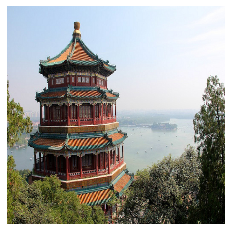

In [35]:
images_resized = tf.image.resize(images, [224, 224])
plot_color_image(images_resized[0])
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


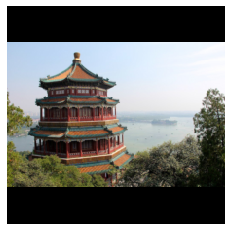

In [36]:
images_resized = tf.image.resize_with_pad(images, 224, 224, antialias=True)
plot_color_image(images_resized[0])

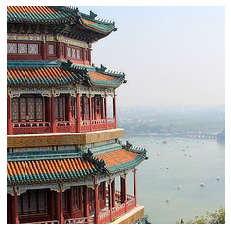

In [37]:
images_resized = tf.image.resize_with_crop_or_pad(images, 224, 224)
plot_color_image(images_resized[0])
plt.show()

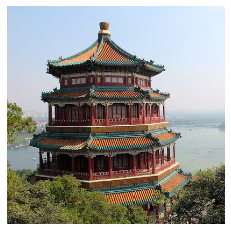

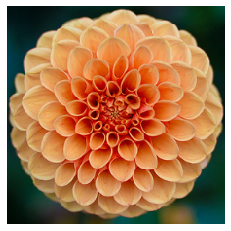

In [38]:
china_box = [0, 0.03, 1, 0.68]
flower_box = [0.19, 0.26, 0.86, 0.7]
images_resized = tf.image.crop_and_resize(images, [china_box, flower_box], [0, 1], [224, 224])
plot_color_image(images_resized[0])
plt.show()
plot_color_image(images_resized[1])
plt.show()

In [39]:
inputs = keras.applications.resnet50.preprocess_input(images_resized * 255)
Y_proba = model.predict(inputs)

In [40]:
Y_proba.shape

(2, 1000)

In [41]:
top_K = keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print("Image #{}".format(image_index))
    for class_id, name, y_proba in top_K[image_index]:
        print("  {} - {:12s} {:.2f}%".format(class_id, name, y_proba * 100))
    print()

Image #0
  n03877845 - palace       43.39%
  n02825657 - bell_cote    43.07%
  n03781244 - monastery    11.70%

Image #1
  n04522168 - vase         53.96%
  n07930864 - cup          9.52%
  n11939491 - daisy        4.97%



# Pretrained Models for Transfer Learning

In [42]:
dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)

In [43]:
dataset_size = info.splits["train"].num_examples

In [44]:
class_names = info.features["label"].names
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [45]:
n_classes = info.features["label"].num_classes
n_classes

5

In [46]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
                                "tf_flowers",
                                split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
                                as_supervised=True)

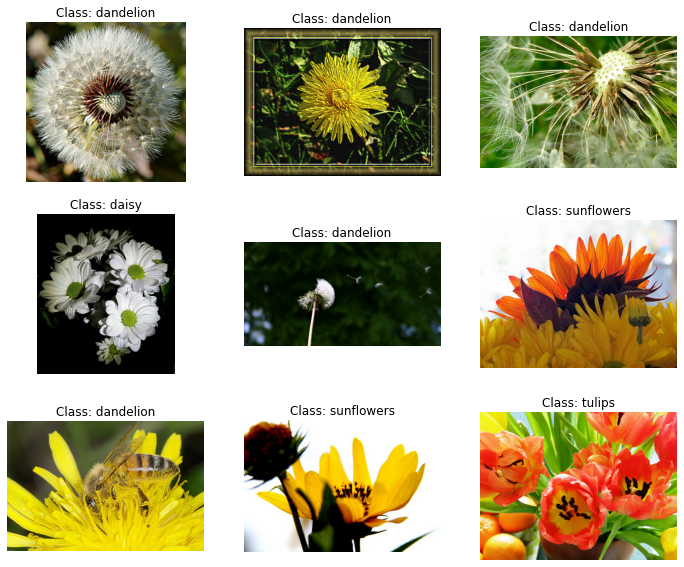

In [47]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in train_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title("Class: {}".format(class_names[label]))
    plt.axis("off")

plt.show()



Basic preprocessing:


In [48]:
def preprocess(image, label):
    resized_image = tf.image.resize(image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

Slightly fancier preprocessing (but we could add much more data augmentation):

In [49]:
def central_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]])
    top_crop = (shape[0] - min_dim) // 4
    bottom_crop = shape[0] - top_crop
    left_crop = (shape[1] - min_dim) // 4
    right_crop = shape[1] - left_crop
    return image[top_crop:bottom_crop, left_crop:right_crop]

def random_crop(image):
    shape = tf.shape(image)
    min_dim = tf.reduce_min([shape[0], shape[1]]) * 90 // 100
    return tf.image.random_crop(image, [min_dim, min_dim, 3])

def preprocess(image, label, randomize=False):
    if randomize:
        cropped_image = random_crop(image)
        cropped_image = tf.image.random_flip_left_right(cropped_image)
    else:
        cropped_image = central_crop(image)
    resized_image = tf.image.resize(cropped_image, [224, 224])
    final_image = keras.applications.xception.preprocess_input(resized_image)
    return final_image, label

batch_size = 32
train_set = train_set_raw.shuffle(1000).repeat()
train_set = train_set.map(partial(preprocess, randomize=True)).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(preprocess).batch(batch_size).prefetch(1)
test_set = test_set_raw.map(preprocess).batch(batch_size).prefetch(1)

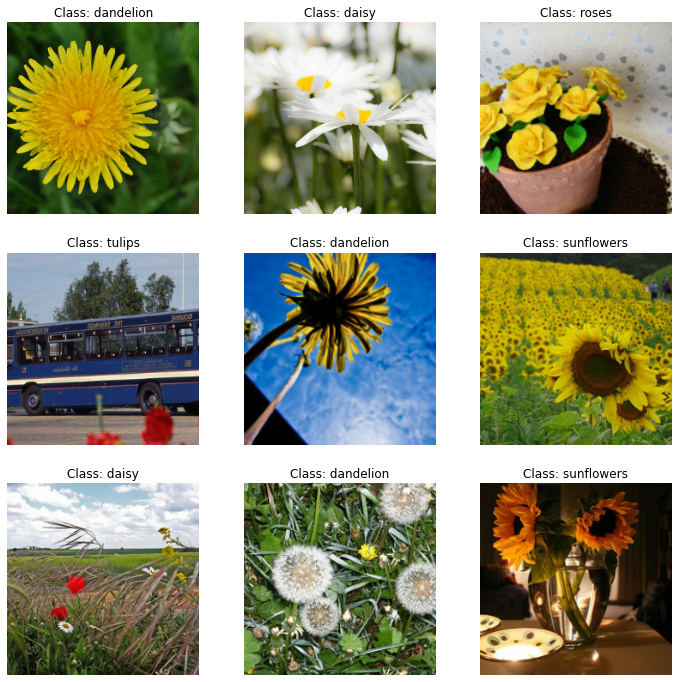

In [50]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in train_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

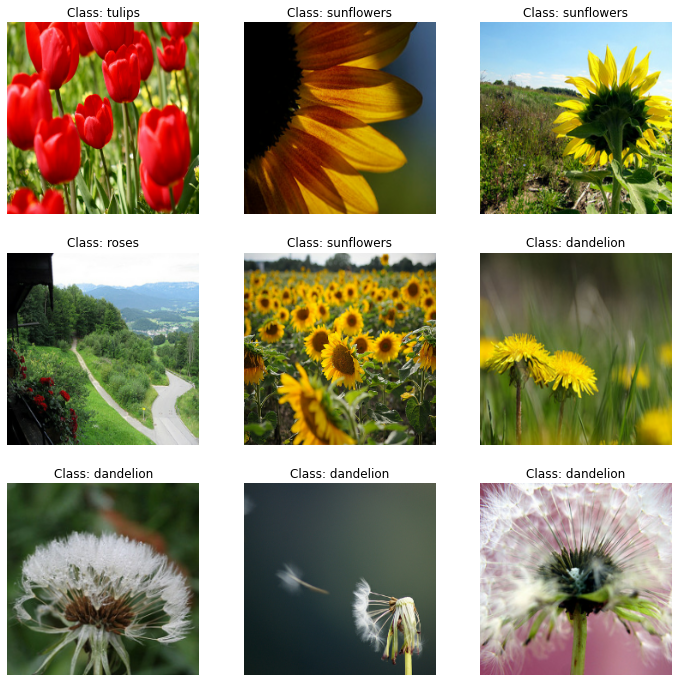

In [51]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in test_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow(X_batch[index] / 2 + 0.5)
        plt.title("Class: {}".format(class_names[y_batch[index]]))
        plt.axis("off")

plt.show()

In [52]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(n_classes, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

In [53]:
for index, layer in enumerate(base_model.layers):
    print(index, layer.name)

0 input_2
1 block1_conv1
2 block1_conv1_bn
3 block1_conv1_act
4 block1_conv2
5 block1_conv2_bn
6 block1_conv2_act
7 block2_sepconv1
8 block2_sepconv1_bn
9 block2_sepconv2_act
10 block2_sepconv2
11 block2_sepconv2_bn
12 conv2d_42
13 block2_pool
14 batch_normalization_36
15 add
16 block3_sepconv1_act
17 block3_sepconv1
18 block3_sepconv1_bn
19 block3_sepconv2_act
20 block3_sepconv2
21 block3_sepconv2_bn
22 conv2d_43
23 block3_pool
24 batch_normalization_37
25 add_1
26 block4_sepconv1_act
27 block4_sepconv1
28 block4_sepconv1_bn
29 block4_sepconv2_act
30 block4_sepconv2
31 block4_sepconv2_bn
32 conv2d_44
33 block4_pool
34 batch_normalization_38
35 add_2
36 block5_sepconv1_act
37 block5_sepconv1
38 block5_sepconv1_bn
39 block5_sepconv2_act
40 block5_sepconv2
41 block5_sepconv2_bn
42 block5_sepconv3_act
43 block5_sepconv3
44 block5_sepconv3_bn
45 add_3
46 block6_sepconv1_act
47 block6_sepconv1
48 block6_sepconv1_bn
49 block6_sepconv2_act
50 block6_sepconv2
51 block6_sepconv2_bn
52 block6_se

In [54]:
for layer in base_model.layers:
    layer.trainable = False

optimizer = keras.optimizers.SGD(learning_rate=0.2, momentum=0.9, decay=0.01)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=5)

Epoch 1/5
86/86 [==============================] - 18s 157ms/step - loss: 1.2839 - accuracy: 0.7958 - val_loss: 0.9828 - val_accuracy: 0.8585
Epoch 2/5
86/86 [==============================] - 13s 150ms/step - loss: 0.5542 - accuracy: 0.8950 - val_loss: 1.3198 - val_accuracy: 0.8346
Epoch 3/5
86/86 [==============================] - 13s 152ms/step - loss: 0.3115 - accuracy: 0.9248 - val_loss: 0.8085 - val_accuracy: 0.8621
Epoch 4/5
86/86 [==============================] - 13s 152ms/step - loss: 0.2298 - accuracy: 0.9382 - val_loss: 0.6962 - val_accuracy: 0.8732
Epoch 5/5
86/86 [==============================] - 13s 151ms/step - loss: 0.2051 - accuracy: 0.9451 - val_loss: 0.6622 - val_accuracy: 0.8713


In [55]:
for layer in base_model.layers:
    layer.trainable = True

optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9,
                                 nesterov=True, decay=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set,
                    steps_per_epoch=int(0.75 * dataset_size / batch_size),
                    validation_data=valid_set,
                    validation_steps=int(0.15 * dataset_size / batch_size),
                    epochs=40)

Epoch 1/40
86/86 [==============================] - 59s 618ms/step - loss: 0.3195 - accuracy: 0.9008 - val_loss: 0.5005 - val_accuracy: 0.8787
Epoch 2/40
86/86 [==============================] - 52s 604ms/step - loss: 0.1266 - accuracy: 0.9600 - val_loss: 0.3152 - val_accuracy: 0.9044
Epoch 3/40
86/86 [==============================] - 53s 615ms/step - loss: 0.0619 - accuracy: 0.9797 - val_loss: 0.2502 - val_accuracy: 0.9136
Epoch 4/40
86/86 [==============================] - 53s 612ms/step - loss: 0.0423 - accuracy: 0.9884 - val_loss: 0.2135 - val_accuracy: 0.9301
Epoch 5/40
86/86 [==============================] - 52s 606ms/step - loss: 0.0348 - accuracy: 0.9884 - val_loss: 0.2275 - val_accuracy: 0.9283
Epoch 6/40
86/86 [==============================] - 52s 607ms/step - loss: 0.0217 - accuracy: 0.9938 - val_loss: 0.2462 - val_accuracy: 0.9393
Epoch 7/40
86/86 [==============================] - 52s 604ms/step - loss: 0.0185 - accuracy: 0.9931 - val_loss: 0.2826 - val_accuracy: 0.9246

# Classification and Localization

In [56]:
base_model = keras.applications.xception.Xception(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = keras.layers.Dense(4)(avg)
model = keras.models.Model(inputs=base_model.input,
                           outputs=[class_output, loc_output])
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2], # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy"])

In [57]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)

In [58]:
model.fit(fake_train_set, steps_per_epoch=5, epochs=2)

Epoch 1/2
5/5 [==============================] - 7s 577ms/step - loss: 1.4447 - dense_5_loss: 1.6913 - dense_6_loss: 0.4583 - dense_5_accuracy: 0.1187 - dense_6_accuracy: 0.3000
Epoch 2/2
5/5 [==============================] - 3s 574ms/step - loss: 1.3498 - dense_5_loss: 1.5955 - dense_6_loss: 0.3672 - dense_5_accuracy: 0.3063 - dense_6_accuracy: 0.2562


# Mean Average Precision (mAP)

In [59]:
def maximum_precisions(precisions):
    return np.flip(np.maximum.accumulate(np.flip(precisions)))

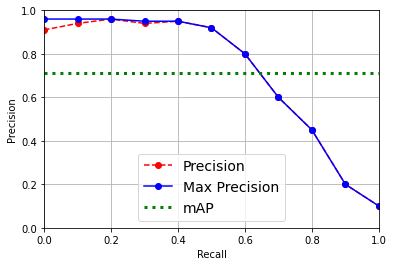

In [60]:
recalls = np.linspace(0, 1, 11)

precisions = [0.91, 0.94, 0.96, 0.94, 0.95, 0.92, 0.80, 0.60, 0.45, 0.20, 0.10]
max_precisions = maximum_precisions(precisions)
mAP = max_precisions.mean()
plt.plot(recalls, precisions, "ro--", label="Precision")
plt.plot(recalls, max_precisions, "bo-", label="Max Precision")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.plot([0, 1], [mAP, mAP], "g:", linewidth=3, label="mAP")
plt.grid(True)
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower center", fontsize=14)
plt.show()

# Transpose convolutions

In [61]:
tf.random.set_seed(42)
X = images_resized.numpy()

conv_transpose = keras.layers.Conv2DTranspose(filters=5, kernel_size=3, strides=2, padding="VALID")
output = conv_transpose(X)
output.shape

TensorShape([2, 449, 449, 5])

In [62]:
X = images_resized.numpy()
X.shape

(2, 224, 224, 3)

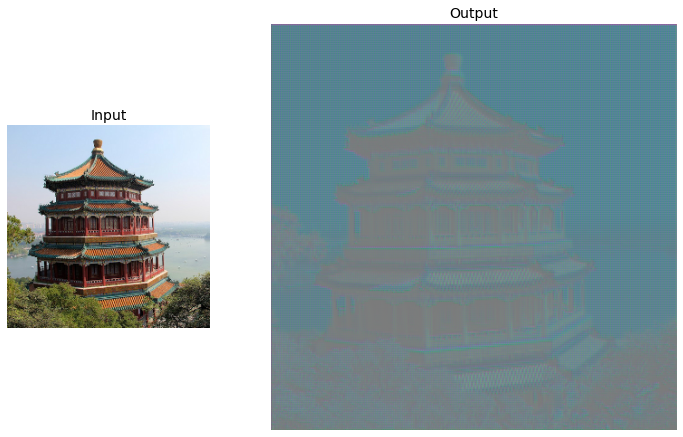

In [63]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[1, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(normalize(output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [64]:
def upscale_images(images, stride, kernel_size):
    batch_size, height, width, channels = images.shape
    upscaled = np.zeros((batch_size,
                         (height - 1) * stride + 2 * kernel_size - 1,
                         (width - 1) * stride + 2 * kernel_size - 1,
                         channels))
    upscaled[:,
             kernel_size - 1:(height - 1) * stride + kernel_size:stride,
             kernel_size - 1:(width - 1) * stride + kernel_size:stride,
             :] = images
    return upscaled

In [65]:
upscaled = upscale_images(X, stride=2, kernel_size=3)
weights, biases = conv_transpose.weights
reversed_filters = np.flip(weights.numpy(), axis=[0, 1])
reversed_filters = np.transpose(reversed_filters, [0, 1, 3, 2])
manual_output = tf.nn.conv2d(upscaled, reversed_filters, strides=1, padding="VALID")

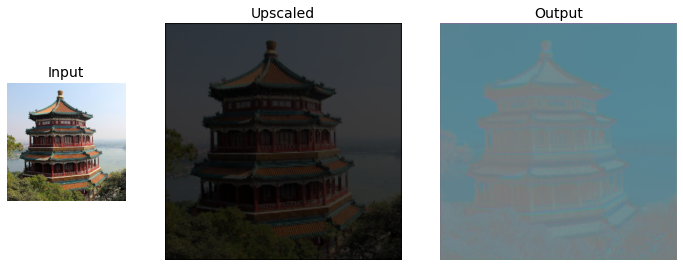

In [66]:
def normalize(X):
    return (X - tf.reduce_min(X)) / (tf.reduce_max(X) - tf.reduce_min(X))

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=3, width_ratios=[1, 2, 2])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(X[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Upscaled", fontsize=14)
ax2.imshow(upscaled[0], interpolation="bicubic")
ax2.axis("off")
ax3 = fig.add_subplot(gs[0, 2])
ax3.set_title("Output", fontsize=14)
ax3.imshow(normalize(manual_output[0, ..., :3]), interpolation="bicubic")  # plot the output for the 1st image
ax3.axis("off")
plt.show()

In [67]:
np.allclose(output, manual_output.numpy(), atol=1e-7)

True

#Exercises

## 9. High Accuracy CNN for MNIST

*Exercise: Build your own CNN from scratch and try to achieve the highest possible accuracy on MNIST.*

The following model uses 2 convolutional layers, followed by 1 pooling layer, then dropout 25%, then a dense layer, another dropout layer but with 50% dropout, and finally the output layer. It reaches about 99.2% accuracy on the test set. This places this model roughly in the top 20% in the MNIST Kaggle competition (if we ignore the models with an accuracy greater than 99.79% which were most likely trained on the test set, as explained by Chris Deotte in this post). Can you do better? To reach 99.5 to 99.7% accuracy on the test set, you need to add image augmentation, batch norm, use a learning schedule such as 1-cycle, and possibly create an ensemble.


In [68]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train_full = X_train_full / 255.
X_test = X_test / 255.
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [69]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, kernel_size=3, padding="same", activation="relu"),
    keras.layers.Conv2D(64, kernel_size=3, padding="same", activation="relu"),
    keras.layers.MaxPool2D(),
    keras.layers.Flatten(),
    keras.layers.Dropout(0.25),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/10
1719/1719 [==============================] - 11s 6ms/step - loss: 0.1981 - accuracy: 0.9398 - val_loss: 0.0424 - val_accuracy: 0.9888
Epoch 2/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0802 - accuracy: 0.9753 - val_loss: 0.0467 - val_accuracy: 0.9874
Epoch 3/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0619 - accuracy: 0.9813 - val_loss: 0.0350 - val_accuracy: 0.9902
Epoch 4/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0513 - accuracy: 0.9842 - val_loss: 0.0339 - val_accuracy: 0.9906
Epoch 5/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0422 - accuracy: 0.9865 - val_loss: 0.0339 - val_accuracy: 0.9926
Epoch 6/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0363 - accuracy: 0.9882 - val_loss: 0.0404 - val_accuracy: 0.9904
Epoch 7/10
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0338 - accuracy: 0.9889 - val_loss: 0.0338 - val_ac

[0.026695001870393753, 0.9927999973297119]